Choosing New Features
==

There are lots of features that could be created here, the first step was to narrow it down to a few  of interest.

**Creating Features from Datetimes**

In particular, for each of `onset-symptoms` and `positive-test-dt` (the two datetime features that I opted to drop), some ideas would be:

Symptoms/Positive Spec reported: Yes/No
Days since `cdc_case_earliest_dt`
Days from fixed point. (Say, 1st Jan 2020)
Days between reporting and now. 

From these, I liked the first for its simplicity and robustness to error.

I also liked the second and fourth, but given the similarity between these datasets and `cdc_case_earliest_dt`, I think most of the relevant information could be captured from `cdc_case_earliest_dt` alone? I'm not certain.


Speaking of `cdc_case_earliest_dt`, the feature describing the number of days between it and today seems very relevant. If the case is very old and the person has not been reported dead yet, they are likely long since recovered.

The tricky bit there is that the dataset is old and out of date. This would make more sense in a setting where the data could be updated regularly. I don't even know when the dataset dates from, which slightly complicates testing the validity of the feature.

All in all, I settled for three features here:<br>
The categorical Yes/No for both `onset_symptoms` and `positive-test-dt`, and the numerical days since first earliest dt.


**Creating a Numerical Feature**

Creating a numerical feature from age might help with both manual statistical analysis and the models, just because numbers are easier to work with.

Of course, all the categorical variables will have to be encoded at some point, and no new information can be captured by doing it now. But having the encoding be the midpoint of each interval rather than arbitrary integers means that numerical plots and descriptive stats can be used.<br>
(I really have no clue if it would help Machine Learning at all)
    

**Encoding Unknown vs Missing** 
   
Earlier on, in part 2, I combined Unknown and Missing into a single value across the table. This is because I felt that they added no new information to their features. 

That being said, there might be an interesting distinction (independent of the missing data) between the two, and this seems like it might be worth encoding into a separate indicator feature.

For example, the feature `icu_yn` could have the feature `icu_status` associated with it which can take the values "Specified", "Missing", or "Unknown".


**Splitting up Race/Eth**

One finally option I considered was splitting up Race and Eth. into subfeatures. I wonder if Black/Asian/White/etc might be useful to have separate from Hispanic/Non-hispanic.


Modifying the Dataset
==

Imports.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import misc

Reading in the dataset.

In [6]:
# Notice that this is data set from part 1!!!
# This is because that while the data is less clean, it does contain some interesting things with
# which to try derive features from.

data = pd.read_csv("data_after_part1.csv", index_col=0)

date_col = "cdc_case_earliest_dt"
data[date_col] = pd.to_datetime(data[date_col], format="%d/%m/%Y")

for field in data.columns[1:]:
    data[field] = data[field].astype("category")

data.head(3)

,cdc_case_earliest_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020-08-25,27/08/2020,25/08/2020,Laboratory-confirmed case,Female,30 - 39 Years,Hispanic/Latino,No,Unknown,No,Unknown
1,2020-12-15,15/12/2020,NaN,Laboratory-confirmed case,Female,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No
2,2020-09-21,NaN,21/09/2020,Laboratory-confirmed case,Female,10 - 19 Years,Unknown,No,Missing,No,Missing


case_age
==

This is the time since the earliest reported date on the case.<br>
It would need to be updated regularly, of course.

In [7]:
data["case_age"] = datetime.now() - data["cdc_case_earliest_dt"]
data["case_age"].head(3)

0   246 days 15:40:02.408061
1   134 days 15:40:02.408061
2   219 days 15:40:02.408061
Name: case_age, dtype: timedelta64[ns]

The result is lot more chaotic then I would like.

In [8]:
data["case_age"].describe()

count                           9290
mean     209 days 14:41:36.186317188
std       87 days 13:00:17.267370600
min         102 days 15:40:02.408061
25%         136 days 15:40:02.408061
50%         176 days 15:40:02.408061
75%         283 days 15:40:02.408061
max         483 days 15:40:02.408061
Name: case_age, dtype: object

There is a slight relationship though, in that cases with deaths seem to be a little more recent than case without deaths on average. 

As of writing this, I have no idea what negative numbers are doing here, though. I think I have missed a fairly important data quality issue.

<AxesSubplot:title={'center':'case_age'}, xlabel='death_yn'>

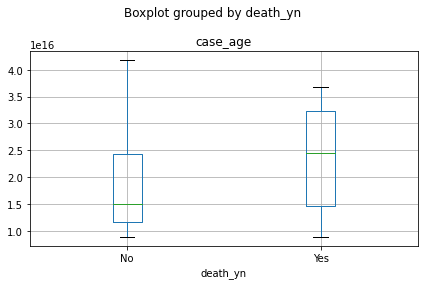

In [9]:
data.boxplot("case_age", by="death_yn")

Before moving on, this is a function for comparing categorical features from the "Relationships" notebook.

In [10]:
def plot_stacked_proportions(x_field, y_field):
    
    stacks = data.value_counts().groupby([x_field, y_field]).sum().unstack()

    stacks = stacks.T

    for column in stacks:
        stacks[column] /= stacks[column].sum()

    stacks.T.plot(kind="bar", stacked=True)

positive_spec_declared
==

Whether or not a positive specimen time is given.

In [11]:
data["pos_spec_declared"] = data["pos_spec_dt"].isna().apply(lambda x: "No" if x else "Yes")
data["pos_spec_declared"] = data["pos_spec_declared"].astype("category")

display(data["pos_spec_declared"].head())

0    Yes
1    Yes
2     No
3     No
4     No
Name: pos_spec_declared, dtype: category
Categories (2, object): ['No', 'Yes']

symptoms_declared
==

Whether or not a specific time is declared for symptoms onset.

In [12]:
data["symptoms_declared"] = data["onset_dt"].isna().apply(lambda x: not x)

display(data["symptoms_declared"].head())

0     True
1    False
2     True
3    False
4    False
Name: symptoms_declared, dtype: bool

In [13]:
# These are the cleanup actions specified in the Action Plan.
data = data.drop("pos_spec_dt", axis=1)
data = data.drop("onset_dt", axis=1)
data = data.replace("Missing", "Unknown")
data = data.replace("OTH", "Unknown")

data.to_csv("data_after_part3.csv")

data.head(3)

,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn,case_age,pos_spec_declared,symptoms_declared
0,2020-08-25,Laboratory-confirmed case,Female,30 - 39 Years,Hispanic/Latino,No,Unknown,No,Unknown,246 days 15:40:02.408061,Yes,True
1,2020-12-15,Laboratory-confirmed case,Female,10 - 19 Years,"Black, Non-Hispanic",No,Unknown,No,No,134 days 15:40:02.408061,Yes,False
2,2020-09-21,Laboratory-confirmed case,Female,10 - 19 Years,Unknown,No,Unknown,No,Unknown,219 days 15:40:02.408061,No,True
